In [128]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics

import seaborn as sns
import pandas as pd
from pandas.io import sql
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py


from sklearn import cluster, metrics

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [14]:
operations = pd.read_csv('../assets/Airport_operations.csv')

In [15]:
cancellations = pd.read_csv('../assets/airport_cancellations.csv')

In [16]:
airports = pd.read_csv('../assets/airports.csv')

In [17]:

delays = 'delays.sqlite'
conn = sqlite3.connect(delays)
conn.text_factory = str
c = conn.cursor()

In [22]:
airports.to_sql('a', con=conn, if_exists='replace', index=False)

In [19]:
cancellations.to_sql('c', con=conn,if_exists='replace', index=False)

In [20]:
operations.to_sql('o', con=conn,if_exists='replace', index=False)

In [23]:
#createca = c.execute('CREATE TABLE ca AS SELECT * FROM a, c WHERE c."Airport" = a."LocID";')

In [24]:
ca = sql.read_sql('SELECT * FROM ca', con=conn)

In [25]:
###Joining Tables

In [26]:
df = sql.read_sql('SELECT * FROM ca INNER JOIN o ON ca.Airport = o.airport AND ca.Year = o.year', con=conn)

In [27]:
df.shape

(799, 34)

In [28]:
nulltest = df

In [29]:
nulltest.dropna(inplace=True)

In [30]:
del df['Key']
del df['Airport']
del df['AP_NAME']
del df['LocID']
del df['ALIAS']
del df['Facility Type']
del df['COUNTY']
del df['AP Type']
del df['Boundary Data Available']

In [31]:
del df['Year']

In [33]:
###Label Encoding

In [51]:
le = LabelEncoder()

airportencode = le.fit_transform(df['airport'])
df['airport'] = airportencode

faaencode = le.fit_transform(df['FAA REGION'])
df['FAA REGION'] = faaencode

cityencode = le.fit_transform(df['CITY'])
df['CITY'] = cityencode

stateencode = le.fit_transform(df['CITY'])
df['STATE'] = stateencode


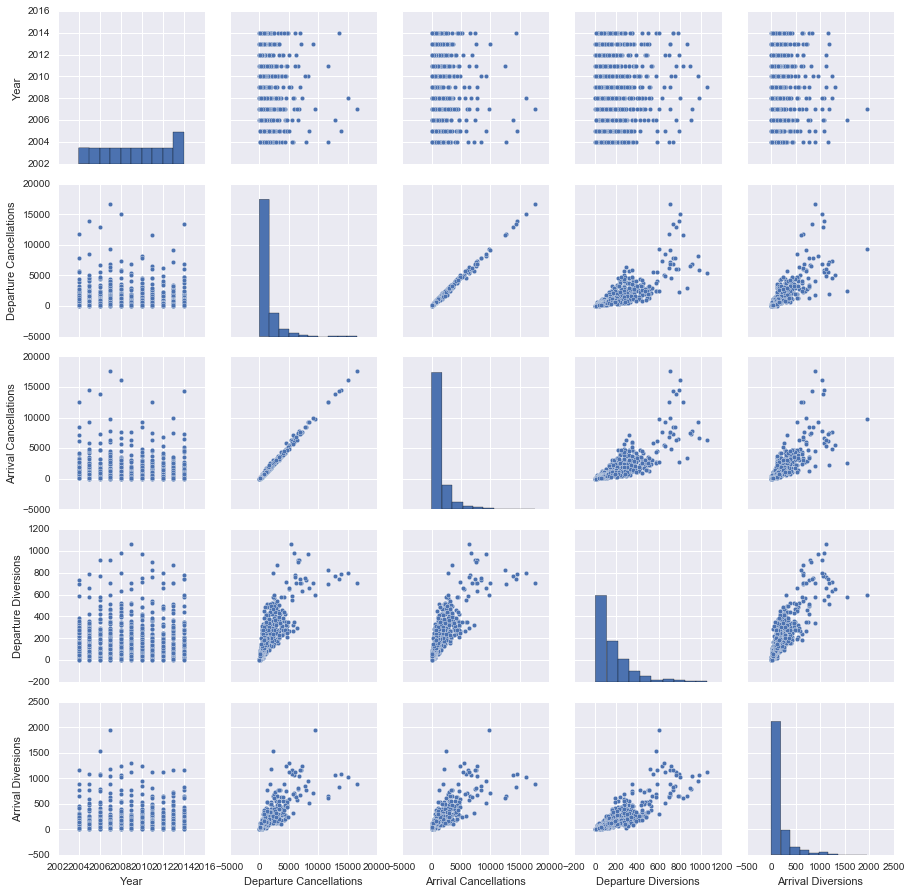

In [59]:
pairplot = sns.pairplot(cancellations)
pairplot

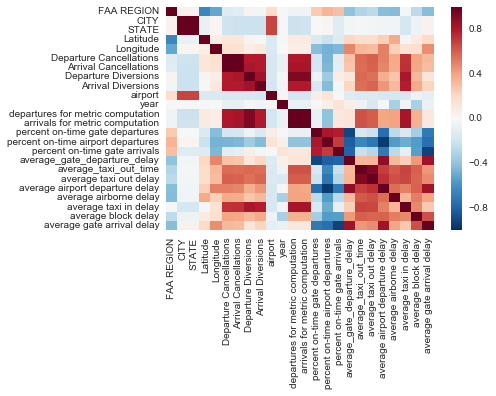

In [60]:
heatmap = sns.heatmap(df.corr(), annot=False)

It's useful to see the correlations between variables before PCA because we can see if there are variables that are highly correlated and drop one.

We can see in the pairplot and the heatmap that "Arrival Cancellations" and "Departure Cancellations" have a correlation near 1.

In [61]:
#del df['Arrival Cancellations']

Now conducting PCA

In [67]:
X = df.values

In [65]:
xStand = StandardScaler().fit_transform(X)

In [69]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [106]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
#for i in eigenPairs:
    #print i[0]

In [104]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)
#print cumulvarExpl

Comparing this to sklearn's PCA Method

In [102]:
pca = PCA(n_components=5)
pca.fit(xStand)
#print("The information (explained variance) contained in each principal component: ", pca.explained_variance_ratio_)
#print(pca.components_)

PCA(copy=True, n_components=5, whiten=False)

In [103]:
W = np.hstack((eigenPairs[0][1].reshape(23,1), eigenPairs[1][1].reshape(23,1)))
X_reduced = xStand.dot(W)
#X_reduced

In [95]:
PC = pd.DataFrame(X_reduced)

In [101]:
###Values for PC1 and PC2
# PC['PC1'] = PC[0]
# PC['PC2'] = PC[1]
# del PC[0]
# del PC[1]
# PC

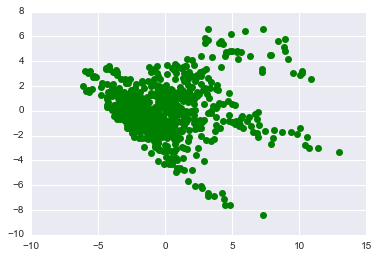

In [110]:
plt.plot(PC['PC1'], PC['PC2'], "og")

In [138]:
PC['Region'] = df['FAA REGION']

In [144]:
PCs = PC.iloc[:, :2]

In [150]:
k = 8
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(PCs)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [151]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_

In [152]:
metrics.silhouette_score(PCs, labels, metric='euclidean')

0.37537007894432656

In [153]:
inertia

1614.6572725982928

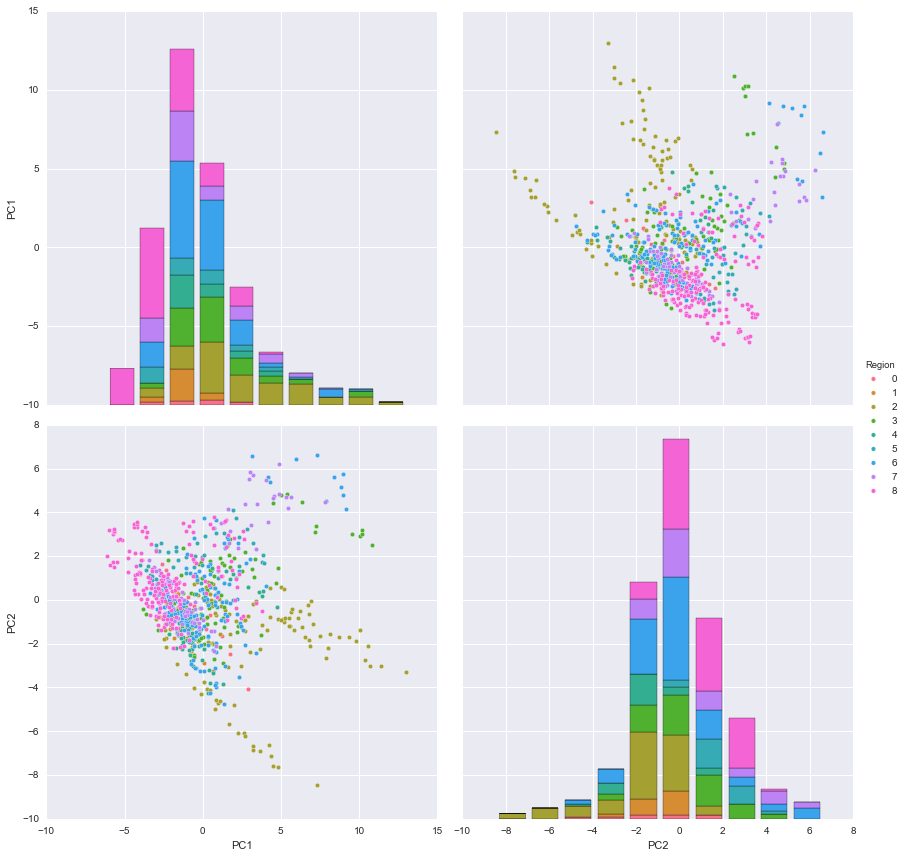

In [170]:
cols = PCs.columns
sns.pairplot(PC, x_vars=cols, y_vars= cols, hue='Region', size=6, aspect=1)

Link to Blog - 